## Peak detection

In [90]:
import numpy as np
import scipy
import scipy.signal
import scipy.interpolate
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd
import csv
from matplotlib import pyplot as plt
DATADIR = "../data-source"
OUTPUTDIR = "./output"

In [91]:
def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

In [92]:
path = f"{DATADIR}/2-11-21/ALL0016/F0016MTH.CSV"
adc_f = openTek(path)['Data'].to_numpy().transpose()
adc_time = adc_f[0]
adc_code = adc_f[1]

In [116]:
p = list(scipy.signal.find_peaks(adc_code * -1., distance=40))[0]
#Other useful parameters:
#prominence
#threshold
#please see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
# ^^^ Fare fine tuning di questi parametri finché non va

# SPLINE
xint = np.linspace(adc_time.min(), adc_time.max(), 500) 
spl = make_interp_spline(adc_time[p], adc_code[p], k=1)  # type: BSpline
interp = spl(xint)

# E' anche interessante provare a cambiare il tipo di interpolazione, per esempio usare una sinc (sinx/x)

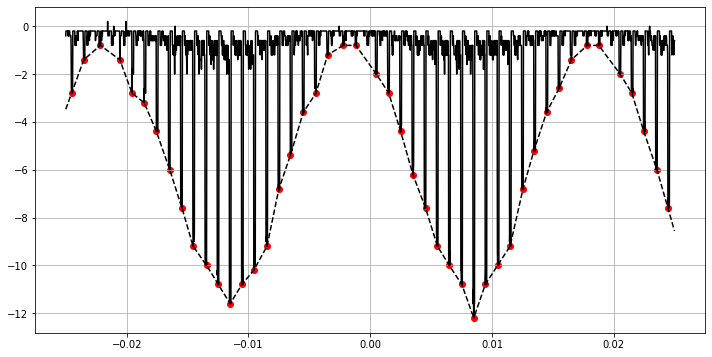

In [114]:
fig, ax = plt.subplots(figsize=(12,6))
ax.grid()
ax.plot(adc_time, adc_code, color='black')
ax.scatter(adc_time[p], adc_code[p], color = "red")
ax.plot(xint, interp, color = "black", linestyle = "--")